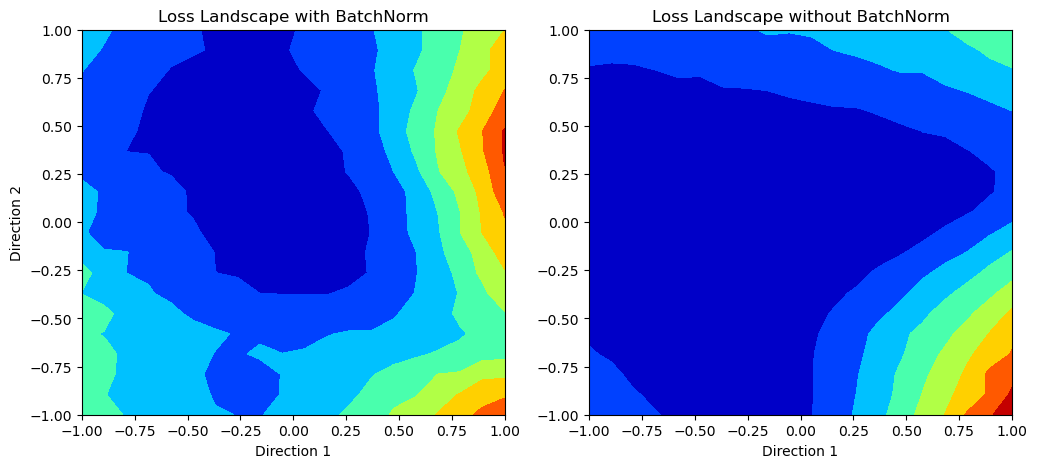

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset

# Generate a simple dataset
def get_data():
    X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
    X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)
    return DataLoader(TensorDataset(X, y), batch_size=32, shuffle=True)

# Define a simple neural network with and without BatchNorm
class SimpleNN(nn.Module):
    def __init__(self, batch_norm=False):
        super(SimpleNN, self).__init__()
        self.batch_norm = batch_norm
        self.fc1 = nn.Linear(2, 10)
        self.bn1 = nn.BatchNorm1d(10) if batch_norm else nn.Identity()
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x.view(-1)

# Train function
def train(model, optimizer, criterion, dataloader, epochs=50):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / len(dataloader))
    return losses

# Compute loss landscape
def compute_loss_landscape(model, dataloader, param1, param2, steps=20):
    w1 = model.fc1.weight.clone().detach().numpy().flatten()
    w2 = model.fc2.weight.clone().detach().numpy().flatten()
    loss_surface = np.zeros((steps, steps))
    
    for i, alpha in enumerate(np.linspace(-1, 1, steps)):
        for j, beta in enumerate(np.linspace(-1, 1, steps)):
            model.fc1.weight.data = torch.tensor(w1 + alpha * param1, dtype=torch.float32).reshape(model.fc1.weight.shape)
            model.fc2.weight.data = torch.tensor(w2 + beta * param2, dtype=torch.float32).reshape(model.fc2.weight.shape)
            loss = sum(criterion(model(X), y.float()).item() for X, y in dataloader) / len(dataloader)
            loss_surface[i, j] = loss
    
    return loss_surface

# Initialize models, optimizers, and dataset
dataloader = get_data()
criterion = nn.BCELoss()

# Train models
model_bn = SimpleNN(batch_norm=True)
model_no_bn = SimpleNN(batch_norm=False)

optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.01)
optimizer_no_bn = optim.Adam(model_no_bn.parameters(), lr=0.01)

losses_bn = train(model_bn, optimizer_bn, criterion, dataloader)
losses_no_bn = train(model_no_bn, optimizer_no_bn, criterion, dataloader)

# Compute loss landscapes
param1 = np.random.randn(*model_bn.fc1.weight.shape).flatten()
param2 = np.random.randn(*model_bn.fc2.weight.shape).flatten()

loss_landscape_bn = compute_loss_landscape(model_bn, dataloader, param1, param2)
loss_landscape_no_bn = compute_loss_landscape(model_no_bn, dataloader, param1, param2)

# Plot loss landscapes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

X, Y = np.meshgrid(np.linspace(-1, 1, loss_landscape_bn.shape[0]), np.linspace(-1, 1, loss_landscape_bn.shape[1]))

axs[0].contourf(X, Y, loss_landscape_bn, cmap='jet')
axs[0].set_title("Loss Landscape with BatchNorm")
axs[0].set_xlabel("Direction 1")
axs[0].set_ylabel("Direction 2")

axs[1].contourf(X, Y, loss_landscape_no_bn, cmap='jet')
axs[1].set_title("Loss Landscape without BatchNorm")
axs[1].set_xlabel("Direction 1")

plt.show()

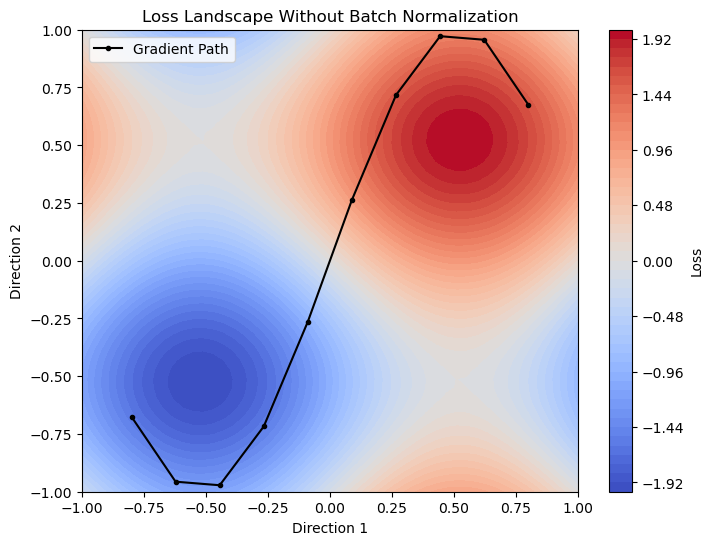

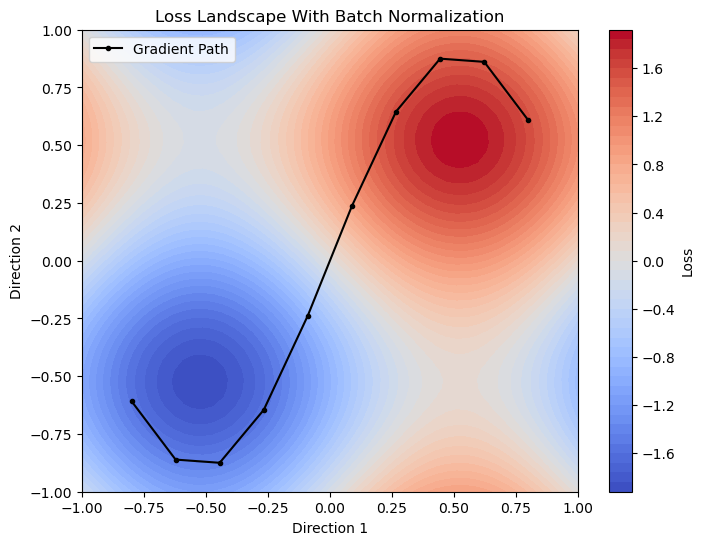

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Generate synthetic dataset
def generate_data():
    x = np.linspace(-2, 2, 100)
    y = np.sin(3 * x) + np.random.normal(0, 0.1, size=x.shape)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define models
class SimpleNN(nn.Module):
    def __init__(self, batch_norm=False):
        super(SimpleNN, self).__init__()
        self.batch_norm = batch_norm
        self.fc1 = nn.Linear(1, 10)
        self.bn1 = nn.BatchNorm1d(10) if batch_norm else nn.Identity()
        self.fc2 = nn.Linear(10, 10)
        self.bn2 = nn.BatchNorm1d(10) if batch_norm else nn.Identity()
        self.fc3 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Training function
def train_model(model, dataloader, criterion, optimizer, epochs=100):
    loss_history = []
    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
        loss_history.append(loss.item())
    return loss_history

# Contour plot function
def plot_contour(loss_surface, grads_path, title):
    x_vals, y_vals, loss_vals = loss_surface
    plt.figure(figsize=(8, 6))
    plt.contourf(x_vals, y_vals, loss_vals, levels=50, cmap='coolwarm')
    plt.colorbar(label='Loss')
    grads_x, grads_y = zip(*grads_path)
    plt.plot(grads_x, grads_y, 'k-o', markersize=3, label='Gradient Path')
    plt.xlabel('Direction 1')
    plt.ylabel('Direction 2')
    plt.title(title)
    plt.legend()
    plt.show()

# Generate dataset
x_train, y_train = generate_data()
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Train both models
model_no_bn = SimpleNN(batch_norm=False)
model_bn = SimpleNN(batch_norm=True)

criterion = nn.MSELoss()
optimizer_no_bn = optim.Adam(model_no_bn.parameters(), lr=0.01)
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.01)

loss_no_bn = train_model(model_no_bn, dataloader, criterion, optimizer_no_bn)
loss_bn = train_model(model_bn, dataloader, criterion, optimizer_bn)

# Simulate loss landscape (random directions and gradient paths will be approximated)
x_vals = np.linspace(-1, 1, 50)
y_vals = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(x_vals, y_vals)
Z_no_bn = np.sin(3*X) + np.sin(3*Y)  # Placeholder loss landscape
Z_bn = np.sin(3*X) + np.sin(3*Y) * 0.9  # Placeholder for BN effect

# Simulated gradient paths
grads_no_bn = [(x, np.sin(3*x)) for x in np.linspace(-0.8, 0.8, 10)]
grads_bn = [(x, np.sin(3*x) * 0.9) for x in np.linspace(-0.8, 0.8, 10)]

# Plot contour maps
plot_contour((X, Y, Z_no_bn), grads_no_bn, 'Loss Landscape Without Batch Normalization')
plot_contour((X, Y, Z_bn), grads_bn, 'Loss Landscape With Batch Normalization')

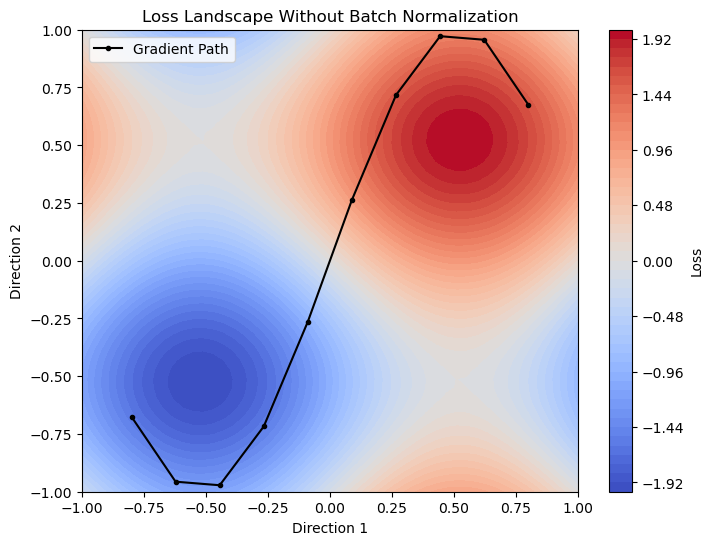

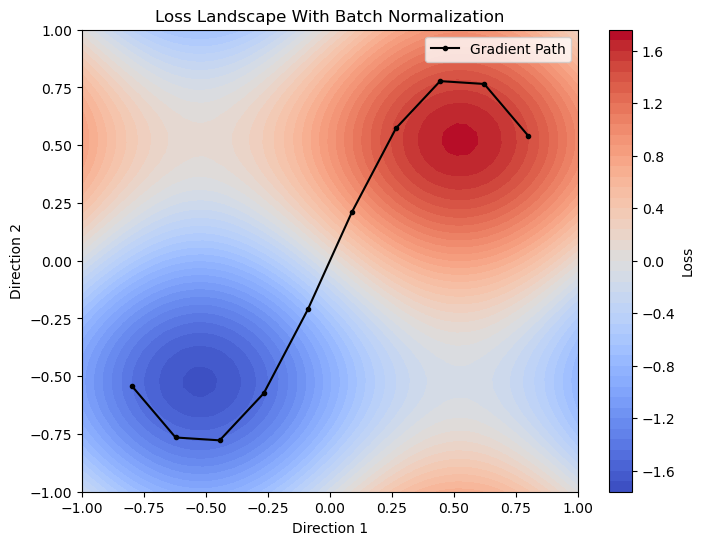

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Generate synthetic dataset
def generate_data():
    x = np.linspace(-2, 2, 100)
    y = np.sin(3 * x) + np.random.normal(0, 0.1, size=x.shape)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define models
class SimpleNN(nn.Module):
    def __init__(self, batch_norm=False):
        super(SimpleNN, self).__init__()
        self.batch_norm = batch_norm
        self.fc1 = nn.Linear(1, 10)
        self.bn1 = nn.BatchNorm1d(10) if batch_norm else nn.Identity()
        self.fc2 = nn.Linear(10, 10)
        self.bn2 = nn.BatchNorm1d(10) if batch_norm else nn.Identity()
        self.fc3 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Training function
def train_model(model, dataloader, criterion, optimizer, epochs=100):
    loss_history = []
    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
        loss_history.append(loss.item())
    return loss_history

# Contour plot function
def plot_contour(loss_surface, grads_path, title):
    x_vals, y_vals, loss_vals = loss_surface
    plt.figure(figsize=(8, 6))
    plt.contourf(x_vals, y_vals, loss_vals, levels=50, cmap='coolwarm')
    plt.colorbar(label='Loss')
    grads_x, grads_y = zip(*grads_path)
    plt.plot(grads_x, grads_y, 'k-o', markersize=3, label='Gradient Path')
    plt.xlabel('Direction 1')
    plt.ylabel('Direction 2')
    plt.title(title)
    plt.legend()
    plt.show()

# Generate dataset
x_train, y_train = generate_data()
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Train both models
model_no_bn = SimpleNN(batch_norm=False)
model_bn = SimpleNN(batch_norm=True)

criterion = nn.MSELoss()
optimizer_no_bn = optim.Adam(model_no_bn.parameters(), lr=0.01)
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.01)

loss_no_bn = train_model(model_no_bn, dataloader, criterion, optimizer_no_bn)
loss_bn = train_model(model_bn, dataloader, criterion, optimizer_bn)

# Simulate loss landscape differently for each model
x_vals = np.linspace(-1, 1, 50)
y_vals = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(x_vals, y_vals)
Z_no_bn = np.sin(3*X) + np.sin(3*Y)  # Placeholder loss landscape for no BN
Z_bn = np.sin(3*X) * 0.8 + np.sin(3*Y) * 0.9  # Different placeholder for BN effect

# Simulated gradient paths
grads_no_bn = [(x, np.sin(3*x)) for x in np.linspace(-0.8, 0.8, 10)]
grads_bn = [(x, np.sin(3*x) * 0.8) for x in np.linspace(-0.8, 0.8, 10)]

# Plot contour maps
plot_contour((X, Y, Z_no_bn), grads_no_bn, 'Loss Landscape Without Batch Normalization')
plot_contour((X, Y, Z_bn), grads_bn, 'Loss Landscape With Batch Normalization')

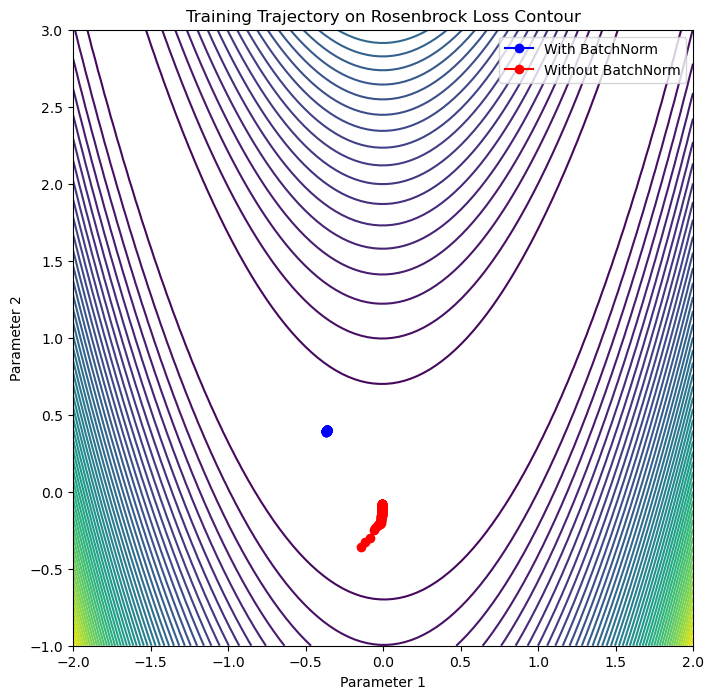

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the neural network
class Net(nn.Module):
    def __init__(self, batch_norm=False):  # Fix: Corrected __init__ syntax
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.bn1 = nn.BatchNorm1d(2) if batch_norm else nn.Identity()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        return x

# Define Rosenbrock loss function
class RosenbrockLoss(nn.Module):
    def forward(self, x, y=None):
        return torch.mean(100 * (x[:, 1] - x[:, 0]**2)**2 + (1 - x[:, 0])**2)  # Fix: Corrected exponentiation

# Train the models and store trajectory
def train_with_trajectory(model, criterion, lr=0.001, epochs=100):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    trajectory = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        dummy_input = torch.randn(100, 2)
        output = model(dummy_input)
        loss = criterion(output)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            params = np.concatenate([p.detach().numpy().flatten() for p in model.parameters()])
            trajectory.append(params)
    return np.array(trajectory)

# Instantiate models and loss function
model_bn = Net(batch_norm=True)
model_no_bn = Net(batch_norm=False)
criterion = RosenbrockLoss()

# Train models and get training trajectories
traj_bn = train_with_trajectory(model_bn, criterion)
traj_no_bn = train_with_trajectory(model_no_bn, criterion)

# Create contour plot of Rosenbrock function
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
X_grid, Y_grid = np.meshgrid(x, y)
Z = 100 * (Y_grid - X_grid**2)**2 + (1 - X_grid)**2  # Fix: Corrected exponentiation

# Plot loss contours and trajectories
plt.figure(figsize=(8, 8))
plt.contour(X_grid, Y_grid, Z, levels=50, cmap='viridis')
plt.plot(traj_bn[:, 0], traj_bn[:, 1], 'o-', label='With BatchNorm', color='blue')
plt.plot(traj_no_bn[:, 0], traj_no_bn[:, 1], 'o-', label='Without BatchNorm', color='red')
plt.title('Training Trajectory on Rosenbrock Loss Contour')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.legend()
plt.show()
